# Week-06 (NN with Keras and Hyperparameter Tuning with Keras-Tuner)

Kembali ke [Sains Data](../sainsdata2023.qmd)

Pada modul kali ini kita akan mempelajari lebih lanjut implementasi Neural Network menggunakan Keras API serta cara melakukan hyperparameter tuning menggunakan library Keras-Tuner.

Penjelasan modul serta code pada modul ini akan dibahas lengkap pada sesi praktikum. Penjelasan pada notebook ini hanyalah ringkasan singkat. 

## Prerequisites

In [5]:
!pip install keras-tuner
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.5 MB/s eta 0:00:00


## Build Image Classifier with **Sequential API** 

Keras memiliki tiga macam API yang dapat digunakan, yaitu Sequential, Functional, dan Subclassing. Ketiganya memiliki kelebihan dan kekurangan masing-masing, terutama di sisi kemudahan dan fleksibilitas.

**Sequential API** merupakan API yang sangat mudah dipahami bagi semua orang yang ingin mempelajari deep learning, tetapi Sequential tidak cukup fleksibel dalam membuat arsitektur model tingkat lanjut karena sifatnya yang mengharuskan tiap layer terhubung satu sama lain dari input hingga output.

**Functional API** merupakan API yang juga cukup mudah dipahami (sedikit lebih kompleks dibandingkan Sequential), tetapi cukup fleksibel dalam mengimplementasikan beragam arsitektur model.

**Subclassing API** merupakan API yang cukup sulit dipahami bagi orang yang baru ingin mempelajari deep learning, tetapi di sisi lain API ini merupakan API terfleksibel pada Keras.

Pada modul ini, hanya akan dibahas Sequential dan Functional API.

Pertama, kita akan membuat dua macam model untuk mengklasifikasikan gambar *fashion* (computer vision). Pertama, kita akan membuat model ANN yang cukup simple, kemudian kita coba model CNN untuk meningkatkan akurasi.

### Data Preparation
https://keras.io/api/datasets/fashion_mnist/

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [7]:
print(f'X_train_full shape: {X_train_full.shape}')
print(f'y_train_full shape: {y_train_full.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train_full shape: (60000, 28, 28)
y_train_full shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                  test_size=1/6, 
                                                  random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (50000, 28, 28)
y_train shape: (50000,)
X_val shape: (10000, 28, 28)
y_val shape: (10000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [9]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

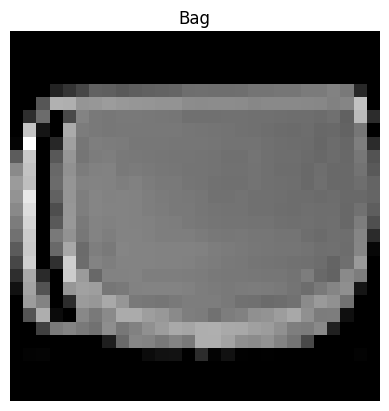

In [11]:
#@title Slider to look for some image examples {run: "auto"}
idx = 21402 #@param {type:"slider", min:0, max:49999, step:1}

plt.imshow(X_train[idx], cmap='gray')
plt.title(class_names[y_train[idx]])
plt.axis('OFF')
plt.show()

### Simple ANN

#### Without callbacks

In [65]:
model_ann_class = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_ann_class.compile(optimizer=opt, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_ann_class.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


In [67]:
init_ann_class_weights = model_ann_class.get_weights()

In [86]:
print(type(init_ann_class_weights))
print(len(init_ann_class_weights))
print(f'First dense w: {init_ann_class_weights[0].shape}')
print(f'First dense b: {init_ann_class_weights[1].shape}')
print(f'Second dense w: {init_ann_class_weights[2].shape}')
print(f'Second dense b: {init_ann_class_weights[3].shape}')
print(f'Last dense w: {init_ann_class_weights[4].shape}')
print(f'Last dense b: {init_ann_class_weights[5].shape}')

<class 'list'>
6
First dense w: (784, 100)
First dense b: (100,)
Second dense w: (100, 50)
Second dense b: (50,)
Last dense w: (50, 10)
Last dense b: (10,)


In [73]:
history_ann_class = model_ann_class.fit(X_train, y_train, 
                                        validation_data=(X_val, y_val),
                                        epochs=50, batch_size=256)

Epoch 1/50
196/196 [==============================] - 2s 9ms/step - loss: 0.6681 - accuracy: 0.7688 - val_loss: 0.4915 - val_accuracy: 0.8307
Epoch 2/50
196/196 [==============================] - 2s 11ms/step - loss: 0.4334 - accuracy: 0.8471 - val_loss: 0.4150 - val_accuracy: 0.8491
Epoch 3/50
196/196 [==============================] - 1s 7ms/step - loss: 0.3873 - accuracy: 0.8635 - val_loss: 0.4204 - val_accuracy: 0.8503
Epoch 4/50
196/196 [==============================] - 1s 7ms/step - loss: 0.3637 - accuracy: 0.8700 - val_loss: 0.3839 - val_accuracy: 0.8600
Epoch 5/50
196/196 [==============================] - 1s 7ms/step - loss: 0.3422 - accuracy: 0.8768 - val_loss: 0.3612 - val_accuracy: 0.8720
Epoch 6/50
196/196 [==============================] - 1s 7ms/step - loss: 0.3275 - accuracy: 0.8805 - val_loss: 0.3525 - val_accuracy: 0.8732
Epoch 7/50
196/196 [==============================] - 1s 8ms/step - loss: 0.3116 - accuracy: 0.8868 - val_loss: 0.3400 - val_accuracy: 0.8747
Epoch

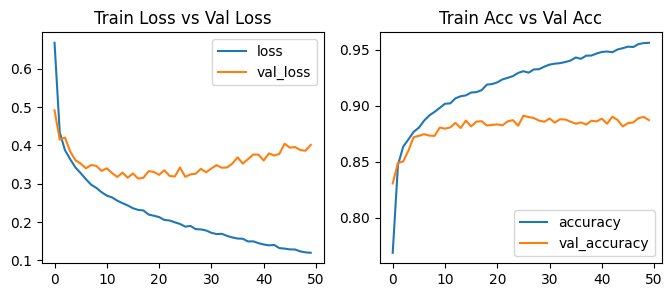

In [74]:
loss = history_ann_class.history['loss']
val_loss = history_ann_class.history['val_loss']
accuracy = history_ann_class.history['accuracy']
val_accuracy = history_ann_class.history['val_accuracy']
epochs = range(len(loss))

fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(epochs, loss)
ax[0].plot(epochs, val_loss)
ax[0].legend(['loss', 'val_loss'], loc='upper right')
ax[0].set_title('Train Loss vs Val Loss')
ax[1].plot(epochs, accuracy)
ax[1].plot(epochs, val_accuracy)
ax[1].legend(['accuracy', 'val_accuracy'], loc='lower right')
ax[1].set_title('Train Acc vs Val Acc')
plt.show()

In [75]:
model_ann_class.evaluate(X_val, y_val)

313/313 [==============================] - 1s 4ms/step - loss: 0.4013 - accuracy: 0.8872


[0.4012959599494934, 0.8871999979019165]

In [76]:
model_ann_class.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.4228 - accuracy: 0.8853


[0.42284178733825684, 0.8852999806404114]

#### With callbacks

In [77]:
model_ann_class.set_weights(init_ann_class_weights)

In [78]:
model_ann_class.evaluate(X_val, y_val)

313/313 [==============================] - 1s 2ms/step - loss: 2.4112 - accuracy: 0.0420


[2.41121768951416, 0.041999999433755875]

In [80]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

history_ann_class = model_ann_class.fit(X_train, y_train, 
                                        validation_data=(X_val, y_val),
                                        epochs=50, batch_size=256,
                                        callbacks=[early_stop])

Epoch 1/50
196/196 [==============================] - 1s 7ms/step - loss: 0.6287 - accuracy: 0.7787 - val_loss: 0.4691 - val_accuracy: 0.8378
Epoch 2/50
196/196 [==============================] - 1s 7ms/step - loss: 0.4224 - accuracy: 0.8508 - val_loss: 0.4133 - val_accuracy: 0.8549
Epoch 3/50
196/196 [==============================] - 1s 7ms/step - loss: 0.3808 - accuracy: 0.8663 - val_loss: 0.3827 - val_accuracy: 0.8651
Epoch 4/50
196/196 [==============================] - 1s 7ms/step - loss: 0.3479 - accuracy: 0.8757 - val_loss: 0.3823 - val_accuracy: 0.8636
Epoch 5/50
196/196 [==============================] - 2s 9ms/step - loss: 0.3341 - accuracy: 0.8803 - val_loss: 0.3610 - val_accuracy: 0.8732
Epoch 6/50
196/196 [==============================] - 2s 11ms/step - loss: 0.3199 - accuracy: 0.8852 - val_loss: 0.3534 - val_accuracy: 0.8746
Epoch 7/50
196/196 [==============================] - 1s 7ms/step - loss: 0.3079 - accuracy: 0.8888 - val_loss: 0.3383 - val_accuracy: 0.8785
Epoch

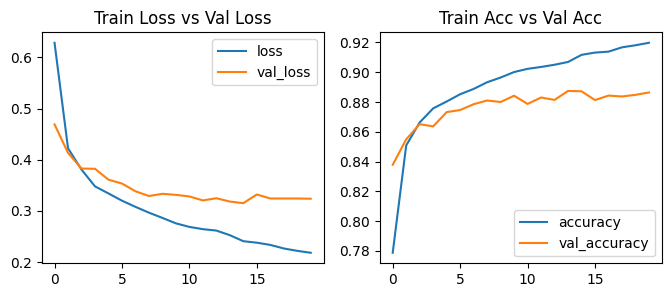

In [83]:
loss = history_ann_class.history['loss']
val_loss = history_ann_class.history['val_loss']
accuracy = history_ann_class.history['accuracy']
val_accuracy = history_ann_class.history['val_accuracy']
epochs = range(len(loss))

fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(epochs, loss)
ax[0].plot(epochs, val_loss)
ax[0].legend(['loss', 'val_loss'], loc='upper right')
ax[0].set_title('Train Loss vs Val Loss')
ax[1].plot(epochs, accuracy)
ax[1].plot(epochs, val_accuracy)
ax[1].legend(['accuracy', 'val_accuracy'], loc='lower right')
ax[1].set_title('Train Acc vs Val Acc')
plt.show()

In [84]:
model_ann_class.evaluate(X_val, y_val)

313/313 [==============================] - 1s 4ms/step - loss: 0.3150 - accuracy: 0.8872


[0.31500566005706787, 0.8871999979019165]

In [85]:
model_ann_class.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3424 - accuracy: 0.8841


[0.342407763004303, 0.8841000199317932]

### CNN

In [22]:
tf.keras.backend.clear_session()

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5),
                           activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics='accuracy')

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 100)               1

In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

history_cnn = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=100, batch_size=256, 
                            callbacks=[early_stop])

Epoch 1/100
196/196 [==============================] - 4s 9ms/step - loss: 0.7431 - accuracy: 0.7296 - val_loss: 0.4864 - val_accuracy: 0.8231
Epoch 2/100
196/196 [==============================] - 1s 7ms/step - loss: 0.4358 - accuracy: 0.8453 - val_loss: 0.4050 - val_accuracy: 0.8536
Epoch 3/100
196/196 [==============================] - 1s 7ms/step - loss: 0.3686 - accuracy: 0.8686 - val_loss: 0.3497 - val_accuracy: 0.8712
Epoch 4/100
196/196 [==============================] - 1s 6ms/step - loss: 0.3341 - accuracy: 0.8812 - val_loss: 0.3283 - val_accuracy: 0.8801
Epoch 5/100
196/196 [==============================] - 1s 6ms/step - loss: 0.3081 - accuracy: 0.8892 - val_loss: 0.3191 - val_accuracy: 0.8836
Epoch 6/100
196/196 [==============================] - 1s 6ms/step - loss: 0.2845 - accuracy: 0.8986 - val_loss: 0.3178 - val_accuracy: 0.8832
Epoch 7/100
196/196 [==============================] - 1s 6ms/step - loss: 0.2725 - accuracy: 0.9018 - val_loss: 0.2926 - val_accuracy: 0.8930

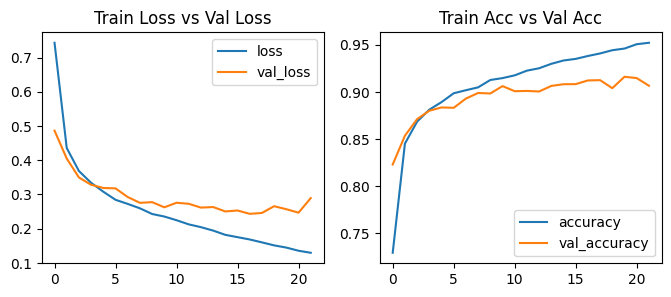

In [24]:
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']
epochs = range(len(loss))

fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(epochs, loss)
ax[0].plot(epochs, val_loss)
ax[0].legend(['loss', 'val_loss'], loc='upper right')
ax[0].set_title('Train Loss vs Val Loss')
ax[1].plot(epochs, accuracy)
ax[1].plot(epochs, val_accuracy)
ax[1].legend(['accuracy', 'val_accuracy'], loc='lower right')
ax[1].set_title('Train Acc vs Val Acc')
plt.show()

In [25]:
model_cnn.evaluate(X_val, y_val)

313/313 [==============================] - 1s 3ms/step - loss: 0.2435 - accuracy: 0.9122


[0.2434857189655304, 0.9121999740600586]

In [26]:
model_cnn.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2664 - accuracy: 0.9079


[0.26635172963142395, 0.9078999757766724]

In [31]:
y_pred = tf.argmax(model_cnn.predict(X_test), axis=-1).numpy()
y_pred[:10], y_test[:10]

313/313 [==============================] - 1s 2ms/step


(array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]),
 array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8))

Prediction: Coat
Truth: Pullover


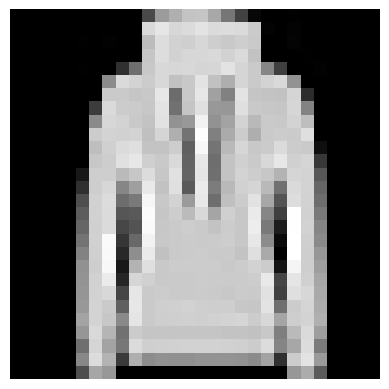

In [53]:
#@title Wrong Prediction image {run:"auto"}

wrong_pred = (y_pred != y_test)

wrong_pred_idx = 8 #@param {type:"slider", min:0, max:20, step:1}

print(f'Prediction: {class_names[y_pred[wrong_pred][wrong_pred_idx]]}')
print(f'Truth: {class_names[y_test[wrong_pred][wrong_pred_idx]]}')

plt.imshow(X_test[wrong_pred][wrong_pred_idx], cmap='gray')
plt.axis('OFF')
plt.show()

## Build NN Regressor with **Sequential API**

Selanjutnya, kita coba untuk membuat model ANN untuk masalah regresi (harga rumah).

### Data Preparation

In [55]:
housing = fetch_california_housing()
X = housing['data']
y = housing['target']

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (20640, 8)
y shape: (20640,)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4,
                                                    random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5,
                                                random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (12384, 8)
y_train shape: (12384,)
X_val shape: (4128, 8)
y_val shape: (4128,)
X_test shape: (4128, 8)
y_test shape: (4128,)


In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [71]:
print(f'y min: {y_train.min()}')
print(f'y max: {y_train.max()}')

y min: 0.14999
y max: 5.00001


### Modelling

In [84]:
tf.keras.backend.clear_session()

model_reg = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu',
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1, activation='relu')
])

model_reg.compile(optimizer='adam', loss='mse')

model_reg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                270       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [69]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

history_reg = model_reg.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=500, callbacks=[early_stop])

Epoch 1/500
387/387 [==============================] - 2s 3ms/step - loss: 1.1266 - val_loss: 0.6397
Epoch 2/500
387/387 [==============================] - 1s 3ms/step - loss: 0.5616 - val_loss: 0.5056
Epoch 3/500
387/387 [==============================] - 1s 3ms/step - loss: 0.4695 - val_loss: 0.4661
Epoch 4/500
387/387 [==============================] - 1s 3ms/step - loss: 0.4385 - val_loss: 0.4433
Epoch 5/500
387/387 [==============================] - 1s 3ms/step - loss: 0.4195 - val_loss: 0.4286
Epoch 6/500
387/387 [==============================] - 1s 3ms/step - loss: 0.4072 - val_loss: 0.4212
Epoch 7/500
387/387 [==============================] - 1s 3ms/step - loss: 0.3966 - val_loss: 0.4100
Epoch 8/500
387/387 [==============================] - 1s 3ms/step - loss: 0.3869 - val_loss: 0.4032
Epoch 9/500
387/387 [==============================] - 1s 4ms/step - loss: 0.3810 - val_loss: 0.3999
Epoch 10/500
387/387 [==============================] - 1s 3ms/step - loss: 0.3751 - val_lo

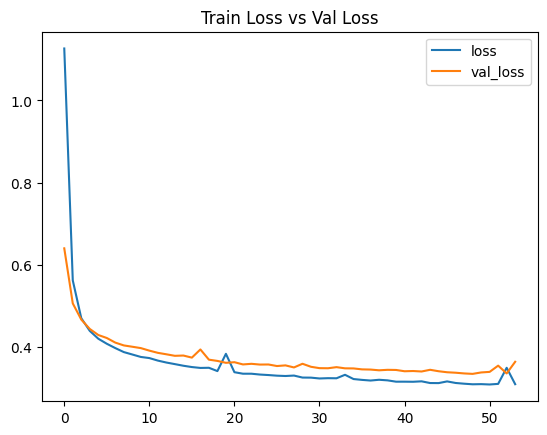

In [70]:
loss = history_reg.history['loss']
val_loss = history_reg.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('Train Loss vs Val Loss')
plt.show()

In [72]:
model_reg.evaluate(X_val, y_val)

129/129 [==============================] - 1s 3ms/step - loss: 0.3338


0.33384060859680176

In [73]:
model_reg.evaluate(X_test, y_test)

129/129 [==============================] - 0s 3ms/step - loss: 0.3242


0.32420143485069275

129/129 [==============================] - 0s 3ms/step


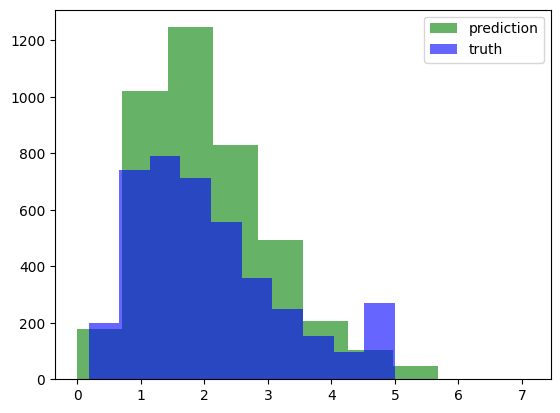

In [82]:
y_pred = model_reg.predict(X_test)

plt.hist(y_pred, color='green', alpha=.6)
plt.hist(y_test, color='blue', alpha=.6)
plt.legend(['prediction', 'truth'], loc='upper right')
plt.show()

## Functional API

Berikut merupakan contoh - contoh penggunaan Functional API. Pada modul ini tidak dibahas banyak karena penggunaannya yang cukup mudah, hanya sedikit berbeda dengan Sequential.

Informasi lebih lanjut dapat dipelajari pada link berikut:
https://keras.io/guides/functional_api/

### Example 1
Membuat NN regressor dengan arsitekur yang sama seperti saat menggunakan Sequential API di atas. 

In [85]:
tf.keras.backend.clear_session()

input_layer = tf.keras.layers.Input(shape=X_train.shape[1:])
dense = tf.keras.layers.Dense(30, activation='relu')(input_layer)
output_layer = tf.keras.layers.Dense(1, activation='relu')(dense)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 30)                270       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


### Example 2
Membuat arsitektur "Wide & Deep" 

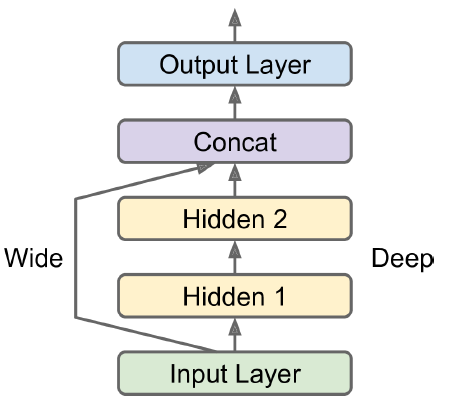

Reference: "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron

In [88]:
tf.keras.backend.clear_session()

input_layer = tf.keras.layers.Input(shape=X_train.shape[1:])
hidden1 = tf.keras.layers.Dense(30, activation="relu")(input_layer)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.Concatenate()([input_layer, hidden2])
output = tf.keras.layers.Dense(1)(concat)

model = tf.keras.Model(inputs=input_layer, outputs=output,
                       name='wide_and_deep')

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "wide_and_deep"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_1[0][0]']    

### Example 3
Membuat arsitektur dengan multiple input

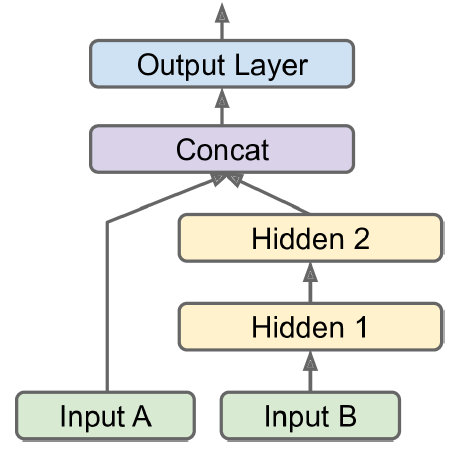

Reference: "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron

In [89]:
tf.keras.backend.clear_session()

input_A = tf.keras.layers.Input(shape=[5], name="wide_input")
input_B = tf.keras.layers.Input(shape=[6], name="deep_input")
hidden1 = tf.keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([input_A, hidden2])
output = tf.keras.layers.Dense(1, name="output")(concat)

model = tf.keras.Model(inputs=[input_A, input_B], outputs=[output],
                       name='multiple_input')

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "multiple_input"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 deep_input (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 30)           210         ['deep_input[0][0]']             
                                                                                                  
 wide_input (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                     

## Hyperparameter Tuning with Keras-Tuner
Pada bagian terakhir dari modul ini, kita akan mencoba melakukan hyperparameter tuning untuk menentukan arsitektur NN terbaik yang menghasilkan `val_loss` terendah.

Informasi lebih lanjut dapat dilihat pada dokumentasi keras-tuner: https://keras.io/api/keras_tuner/

In [92]:
def build_model_reg(hp):
    model = tf.keras.Sequential()
    n_hid_layers = hp.Int('n_hid_layers', 1, 2)
    for layer in range(n_hid_layers):
        n_neurons = hp.Int(f'n_neurons_{layer}', 32, 128, step=16)
        act = hp.Choice(f'activation_{layer}', 
                        ['relu', 'linear', 'sigmoid'])
        model.add(tf.keras.layers.Dense(n_neurons, activation=act))
    
    act_output = hp.Choice('activation_output', ['relu', 'linear'])
    model.add(tf.keras.layers.Dense(1, activation=act_output))

    lr = hp.Float('learning_rate', 1e-5, 1e-2)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')

    return model

### Tuning Process

In [103]:
tf.keras.backend.clear_session()

tuner = kt.BayesianOptimization(hypermodel=build_model_reg,
                                objective='val_loss',
                                max_trials=10,
                                directory='tuner_dir_0',
                                project_name='tune_housing_model')

tuner.search_space_summary()

Search space summary
Default search space size: 5
n_hid_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
n_neurons_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'linear', 'sigmoid'], 'ordered': False}
activation_output (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'linear'], 'ordered': False}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


In [104]:
tuner.search(X_train, y_train, validation_data=(X_val, y_val),
             epochs=100, batch_size=256)

Trial 10 Complete [00h 00m 42s]
val_loss: 0.27770957350730896

Best val_loss So Far: 0.27770957350730896
Total elapsed time: 00h 06m 40s


In [105]:
tuner.results_summary(3)

Results summary
Results in tuner_dir_0/tune_housing_model
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 09 summary
Hyperparameters:
n_hid_layers: 2
n_neurons_0: 48
activation_0: relu
activation_output: linear
learning_rate: 0.00724696590440984
n_neurons_1: 96
activation_1: sigmoid
Score: 0.27770957350730896

Trial 01 summary
Hyperparameters:
n_hid_layers: 2
n_neurons_0: 128
activation_0: sigmoid
activation_output: linear
learning_rate: 0.009038408225650444
n_neurons_1: 64
activation_1: relu
Score: 0.28969764709472656

Trial 02 summary
Hyperparameters:
n_hid_layers: 1
n_neurons_0: 80
activation_0: relu
activation_output: linear
learning_rate: 0.004831622738137635
n_neurons_1: 32
activation_1: relu
Score: 0.3006684482097626


### Retrain best model

In [108]:
model = build_model_reg(tuner.get_best_hyperparameters()[0])
model.build(input_shape=(None,) + X_train.shape[1:])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 48)                432       
                                                                 
 dense_7 (Dense)             (None, 96)                4704      
                                                                 
 dense_8 (Dense)             (None, 1)                 97        
                                                                 
Total params: 5,233
Trainable params: 5,233
Non-trainable params: 0
_________________________________________________________________


In [109]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=500, batch_size=256, callbacks=[early_stop])

Epoch 1/500
49/49 [==============================] - 3s 11ms/step - loss: 1.1235 - val_loss: 0.5184
Epoch 2/500
49/49 [==============================] - 0s 7ms/step - loss: 0.4471 - val_loss: 0.4324
Epoch 3/500
49/49 [==============================] - 0s 6ms/step - loss: 0.3967 - val_loss: 0.4041
Epoch 4/500
49/49 [==============================] - 0s 7ms/step - loss: 0.3720 - val_loss: 0.3898
Epoch 5/500
49/49 [==============================] - 0s 7ms/step - loss: 0.3610 - val_loss: 0.3772
Epoch 6/500
49/49 [==============================] - 0s 6ms/step - loss: 0.3529 - val_loss: 0.3724
Epoch 7/500
49/49 [==============================] - 0s 7ms/step - loss: 0.3494 - val_loss: 0.3672
Epoch 8/500
49/49 [==============================] - 0s 6ms/step - loss: 0.3378 - val_loss: 0.3561
Epoch 9/500
49/49 [==============================] - 0s 5ms/step - loss: 0.3316 - val_loss: 0.3472
Epoch 10/500
49/49 [==============================] - 0s 4ms/step - loss: 0.3279 - val_loss: 0.3419
Epoch 11

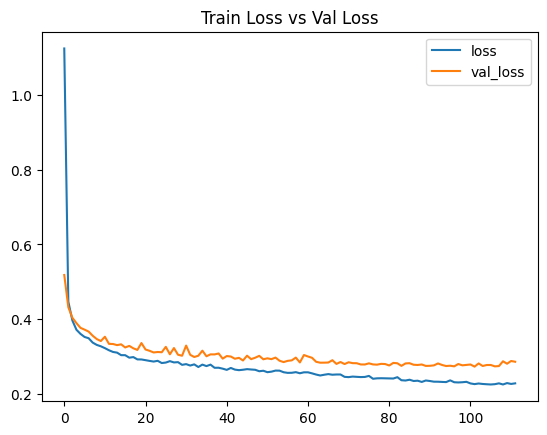

In [110]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.title('Train Loss vs Val Loss')
plt.show()

In [111]:
model.evaluate(X_val, y_val)

129/129 [==============================] - 0s 2ms/step - loss: 0.2736


0.2735856771469116

In [112]:
model.evaluate(X_test, y_test)

129/129 [==============================] - 0s 3ms/step - loss: 0.2652


0.2651788592338562

129/129 [==============================] - 0s 1ms/step


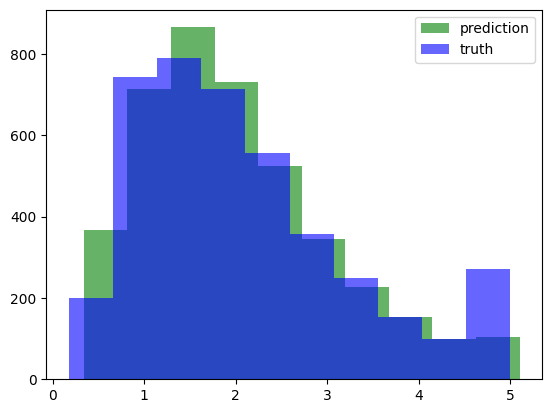

In [113]:
y_pred = model.predict(X_test)

plt.hist(y_pred, color='green', alpha=.6)
plt.hist(y_test, color='blue', alpha=.6)
plt.legend(['prediction', 'truth'], loc='upper right')
plt.show()

## Valuable Resources to Learn More:

- http://neuralnetworksanddeeplearning.com/ (membahas cara kerja neural network secara matematis, cocok untuk yang suka belajar dengan membaca)
- http://introtodeeplearning.com/ (membahas cara kerja neural network hingga CNN, RNN, reinforcement learning, dan lain - lain, cocok untuk yang suka belajar dengan menonton video dan ingin mendalami deep learning lebih lanjut)
- Buku "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron (membahas implementasi Machine Learning dan Deep Learning pada library-library yang tertera di judulnya)